## Exploratory Data Analysis

In [1]:
from __future__ import print_function
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy import random
import matplotlib.ticker as mtick
from datetime import datetime
from pandas import ExcelWriter
from eda_helper import fill_NaN_between_two_columns
from eda_helper import rows_to_del
from eda_helper import createExcel
from eda_helper import rows_to_del_with_index
from eda_helper import catPerMonthGraph2

PROJ_ROOT = os.path.join(os.pardir)
PATH=os.path.abspath(PROJ_ROOT)

In [2]:
#creating df from json file and changing df['date'] to datetime type

df=pd.read_json('anon_transactions.json', orient='records')
df['date']=pd.to_datetime(df['date'], format='%Y-%m-%d')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90086 entries, 0 to 90085
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   accountid             61386 non-null  float64       
 1   address               11940 non-null  object        
 2   amountnum             90086 non-null  float64       
 3   category              88891 non-null  object        
 4   categoryid            61386 non-null  float64       
 5   city                  28772 non-null  object        
 6   client_id             90086 non-null  object        
 7   country               85591 non-null  object        
 8   currency_code         61539 non-null  object        
 9   date                  90086 non-null  datetime64[ns]
 10  detail_category       58398 non-null  float64       
 11  high_level_category   60021 non-null  float64       
 12  latitude              11904 non-null  float64       
 13  longitude       

In [3]:
#There are 29 columns and 90086 rows/entries
df.head()

,accountid,address,amountnum,category,categoryid,city,client_id,country,currency_code,date,...,uid,zip_code,accountId,category0,finsight_api_uid,finsight_image,insight_ctaurl,insight_text,original_uid,tenant_id
0,10204036.0,None,300.00,Transfers,28.0,None,xUNKBjKaHyMto8AeLwVosyPv5jpWdSuK,US,USD,2020-08-20,...,UTaljsLsjma9nB3a3BgRtzfTvWK2,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10092333.0,None,60.00,Credit Card Payments,26.0,None,xUNKBjKaHyMto8AeLwVosyPv5jpWdSuK,US,USD,2020-08-20,...,MqWg0x97h9XwjSCFuxTrKok6JPC3,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10092333.0,None,9.13,Savings,40.0,None,xUNKBjKaHyMto8AeLwVosyPv5jpWdSuK,US,USD,2020-08-20,...,MqWg0x97h9XwjSCFuxTrKok6JPC3,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10092333.0,None,71.68,Transfers,28.0,None,xUNKBjKaHyMto8AeLwVosyPv5jpWdSuK,US,USD,2020-08-20,...,MqWg0x97h9XwjSCFuxTrKok6JPC3,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10092333.0,None,60.00,Credit Card Payments,26.0,None,xUNKBjKaHyMto8AeLwVosyPv5jpWdSuK,US,USD,2020-08-20,...,MqWg0x97h9XwjSCFuxTrKok6JPC3,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data Wrangling

### Deletion of Columns

In [4]:
df.drop(['detail_category','high_level_category','transactionid','client_id','currency_code','country','pending','original_description','category0','finsight_api_uid','finsight_image','insight_ctaurl','insight_text','original_uid','tenant_id','accountId'], axis=1,inplace=True)

#Reasons
#1 deleting [category0','finsight_api_uid','finsight_image','insight_ctaurl','insight_text','original_uid','tenant_id','accountId']
#2 deleting ['client_id',currency_code','country','pending','original_description']as these cols don't add much to the data. country==USA, currency==USD, Pending=1,0 and original_description=simple_description
#3 Looks like if I delete transactionid col I can delete multiple duplicates. its the only col that makes every row differnet even though they are not. 

In [5]:
df.info() #13 cols left

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90086 entries, 0 to 90085
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   accountid           61386 non-null  float64       
 1   address             11940 non-null  object        
 2   amountnum           90086 non-null  float64       
 3   category            88891 non-null  object        
 4   categoryid          61386 non-null  float64       
 5   city                28772 non-null  object        
 6   date                90086 non-null  datetime64[ns]
 7   latitude            11904 non-null  float64       
 8   longitude           11904 non-null  float64       
 9   simple_description  89933 non-null  object        
 10  state               33293 non-null  object        
 11  uid                 90086 non-null  object        
 12  zip_code            11800 non-null  object        
dtypes: datetime64[ns](1), float64(5), object(7)
me

### Dealing with NaN values

#### From df.info() output I can see that there are several columns that could be used to fill NAN values of their "like" columns. For example: zip_code and city columns can be used to fill each others NaN. 
Process: Find a row(#1) with NaN in zip_code and city with some city1 in it. Find another row(#2) where city is set to city1 with corresponding zip_code(#1). Replace NaN of row(#1) with zip_code(#1) as they both have same city

In [6]:
df.info()# Number of non-null values before exchanging 
exchange_list=[['city','zip_code'],['category','categoryid']]
for pair in exchange_list:
    fill_NaN_between_two_columns(df, pair[0], pair[1])
print( '##############')
df.info() # Number of non-null values after exchanging

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90086 entries, 0 to 90085
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   accountid           61386 non-null  float64       
 1   address             11940 non-null  object        
 2   amountnum           90086 non-null  float64       
 3   category            88891 non-null  object        
 4   categoryid          61386 non-null  float64       
 5   city                28772 non-null  object        
 6   date                90086 non-null  datetime64[ns]
 7   latitude            11904 non-null  float64       
 8   longitude           11904 non-null  float64       
 9   simple_description  89933 non-null  object        
 10  state               33293 non-null  object        
 11  uid                 90086 non-null  object        
 12  zip_code            11800 non-null  object        
dtypes: datetime64[ns](1), float64(5), object(7)
me

###### From the latter df.info() above, there is significant gain of values from the exchanges

### Dealing with NaN in 'accountid' using 'uid'

In [7]:
temp=df.groupby('uid')['accountid'].first().to_dict()

for k, v in temp.items():
    if np.isnan(v):
        temp[k]=random.randint(10449313, 10478014)
df['accountid']=df['uid'].map(temp)

#check
assert df[df.accountid.isnull()].empty

In [8]:
#df.info()

### Category Column

Category column needs to understood so we can keep the relevant data and delete non significant data

In [9]:
df['category'].nunique()

66

In [10]:
#8/31 deleting 'Refunds/Adjustments' per Ana's email
#9/2 Adding 'Paychecks/Salary', 'Tax', 'Other Bills' and 'Other Expenses' in kw_list
#9/3 Other expenses and other bills have information not specific to anything. I think it will not help with recomm system.
#9/3: deleting rewards and printing too

kw_list=['Other Bills','Other Expenses','Paychecks/Salary','Tax','Refunds/Adjustments','Transfer','Transfers', 'Interest','Credit Card Payments','Uncategorized','Business Miscellaneous','Paychecks/Salary', 'Insurance', 'Savings', \
           'Other Income','Securities Trades','Deposits', 'Services','Tax','Taxes','Rent', \
           'Mortgages', 'Loans','Investment Income', 'ATM/Cash Withdrawals','Investment Income', 'Loans', \
          'Retirement Contributions','Expense Reimbursement', 'Retirement Income', 'Charitable Giving', 'Bank Fees',\
          'Wages Paid', 'Checks' ,'Rewards','Printing','Payment']
    
rows_to_del(df, 'category', kw_list)

df['category'].nunique() #Unique values after deleting rows with specific categories. 

33

In [11]:
df['category'].unique()

array(['Entertainment', 'Restaurants/Dining', 'Groceries',
       'Gasoline/Fuel', 'Automotive Expenses', 'Clothing/Shoes',
       'Personal Care', 'Cable/Satellite Services', 'General Merchandise',
       'Online Services', 'Telephone Services', 'Electronics',
       'Service Charges/Fees', 'Utilities', 'Gifts', 'Healthcare/Medical',
       'Travel', 'Home Improvement', 'Pets/Pet Care', 'Office Supplies',
       'Hobbies', 'Dues and Subscriptions', 'Child/Dependent Expenses',
       'Advertising', 'Postage and Shipping', 'Education',
       'Home Maintenance', 'Shops', 'Service', 'Recreation',
       'Food and Drink', 'Community', 'Healthcare', nan], dtype=object)

In [12]:
df.reset_index(inplace=True, drop=True)

In [13]:
df.info() #66609 non null entries

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66609 entries, 0 to 66608
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   accountid           66609 non-null  float64       
 1   address             11565 non-null  object        
 2   amountnum           66609 non-null  float64       
 3   category            66446 non-null  object        
 4   categoryid          50406 non-null  float64       
 5   city                26994 non-null  object        
 6   date                66609 non-null  datetime64[ns]
 7   latitude            11681 non-null  float64       
 8   longitude           11681 non-null  float64       
 9   simple_description  66456 non-null  object        
 10  state               30469 non-null  object        
 11  uid                 66609 non-null  object        
 12  zip_code            17323 non-null  object        
dtypes: datetime64[ns](1), float64(5), object(7)
me

In [14]:
#Delete nan values in category col. 

rowstodel=df[df['category'].isnull()].index
df.drop(rowstodel, inplace=True)

df.reset_index(inplace=True, drop=True)

In [15]:
df.info() #66446 rows left.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66446 entries, 0 to 66445
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   accountid           66446 non-null  float64       
 1   address             11565 non-null  object        
 2   amountnum           66446 non-null  float64       
 3   category            66446 non-null  object        
 4   categoryid          50406 non-null  float64       
 5   city                26993 non-null  object        
 6   date                66446 non-null  datetime64[ns]
 7   latitude            11681 non-null  float64       
 8   longitude           11681 non-null  float64       
 9   simple_description  66446 non-null  object        
 10  state               30467 non-null  object        
 11  uid                 66446 non-null  object        
 12  zip_code            17323 non-null  object        
dtypes: datetime64[ns](1), float64(5), object(7)
me

In [16]:
len(df[(df.state.isnull()) & (df.city.isnull())]) #there are 31K rows with no city and state info. 

31077

#### There are still 16K rows where categoryid is still NaN

Which categories don't have a categoryid? 

In [17]:
df[df.categoryid.isnull()].groupby('category').first()

#There are 5 categories that dont have categoryids

,accountid,address,amountnum,categoryid,city,date,latitude,longitude,simple_description,state,uid,zip_code
category,,,,,,,,,,,,
Community,10470140.0,None,5.00,NaN,Raleigh,2020-07-28,43.679749,-70.369019,actblue*our.revolution,MA,1484763731051x184306143783032900,27615
Food and Drink,10472531.0,None,81.74,NaN,Silver Spring,2020-07-28,39.039525,-77.054861,pos/check card withdrawal 2 / ton tonys pizza ...,NY,1492209143433x154222936602309340,20902
Healthcare,10461503.0,None,296.35,NaN,Olathe,2020-07-27,27.099922,-82.415886,atrium health ivr/,NC,1497314003094x504872692516073600,None
Recreation,10473056.0,None,20.00,NaN,Somerville,2020-07-28,30.195284,-81.623947,pos- ops*showcase somer,MA,1495291661851x452172190183773630,None
Service,10474745.0,None,71.79,NaN,Queens,2020-07-28,33.801170,-84.414700,external withdrawal aes - / stdnt loan,None,1593028058784x793431959763337700,None
Shops,10458871.0,154 Samoset St,2.83,NaN,Plymouth,2020-07-28,41.953000,-70.684600,cumberland farms,MA,1490869788516x692722253967076500,02360


In [18]:
#Creating masks for selecting rows with specific category that has NaN in column categoryid. 
#Adding a new number for id in categoryid field of those rows. 

mask = (df['category'] == 'Shops')
df['categoryid'] = df['categoryid'].mask(mask, 201)

mask = (df['category'] == 'Service')
df['categoryid'] = df['categoryid'].mask(mask, 202)

mask = (df['category'] == 'Food and Drink')
df['categoryid'] = df['categoryid'].mask(mask, 203)

mask = (df['category'] == 'Healthcare')
df['categoryid'] = df['categoryid'].mask(mask, 204)

mask = (df['category'] == 'Community')
df['categoryid'] = df['categoryid'].mask(mask, 205)

mask = (df['category'] == 'Recreation')
df['categoryid'] = df['categoryid'].mask(mask, 206)


#Check:
assert df[df.categoryid.isnull()].empty

### Dealing with rows that have <=0 amount (amountnum column) (outliers) 

In [19]:
df['amountnum'].describe() # min value is -ve (could be reimburement of some sort??). 75% of amount is under $52. 
#Max value of 24800 needs to be examined

count    66446.000000
mean        70.168859
std        318.262062
min       -237.430000
25%          9.420000
50%         20.990000
75%         51.467500
max      24800.000000
Name: amountnum, dtype: float64

In [20]:
#Deleting rows that have -ve amount. Seems like those are refunds given to the customers
#Deleting rows that have 0 amount. I dont think these will help us build recomm system 

df[df.amountnum <=0].sort_values(by='category') #100 rows. Shows that these rows are from alot of categories

df[df.amountnum <=0]['category'].unique() #['Service Charges/Fees', 'Travel', 'Clothing/Shoes',
       #'Restaurants/Dining', 'Service', 'Food and Drink', 'Payment',
       #'Shops', 'Gasoline/Fuel', 'Healthcare/Medical', 'Groceries',
       #'General Merchandise', 'Other Expenses', 'Telephone Services',
       #'Gifts', 'Home Improvement', 'Dues and Subscriptions']

rowstodel=df[df.amountnum <=0].index
df.drop(rowstodel, inplace=True)

In [21]:
df['amountnum'].describe() # describe after deleting -ve or 0 amount

count    66353.000000
mean        70.280566
std        318.468438
min          0.010000
25%          9.440000
50%         21.010000
75%         51.530000
max      24800.000000
Name: amountnum, dtype: float64

#### Dealing with Outliers in amountnum

In [22]:
len(df[df.amountnum > 6000]) # since majority of data has amount <=$52 (75% of data), I am considering all amounts > 6000 as outliers

44

In [23]:
#There are only 44 lines in amoutnum>6000 including royal swimming pool stuff. 
#A few airline purchanse of > 8K
# "Other expenses" category has one 61K row and doesn't specify what it is for. 
#Deleting those will not have severe impact on the df

rowstodel=df[df.amountnum > 6000].index
rows_to_del_with_index(df,rowstodel)

df.reset_index(inplace=True, drop=True)

In [24]:
df.info() #non null rows = 69309

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66309 entries, 0 to 66308
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   accountid           66309 non-null  float64       
 1   address             11561 non-null  object        
 2   amountnum           66309 non-null  float64       
 3   category            66309 non-null  object        
 4   categoryid          66309 non-null  float64       
 5   city                26974 non-null  object        
 6   date                66309 non-null  datetime64[ns]
 7   latitude            11677 non-null  float64       
 8   longitude           11677 non-null  float64       
 9   simple_description  66309 non-null  object        
 10  state               30445 non-null  object        
 11  uid                 66309 non-null  object        
 12  zip_code            17317 non-null  object        
dtypes: datetime64[ns](1), float64(5), object(7)
me

In [25]:
df.drop_duplicates(inplace=True)
df.reset_index(inplace=True, drop=True)
df.info() # 52757

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52757 entries, 0 to 52756
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   accountid           52757 non-null  float64       
 1   address             9188 non-null   object        
 2   amountnum           52757 non-null  float64       
 3   category            52757 non-null  object        
 4   categoryid          52757 non-null  float64       
 5   city                20462 non-null  object        
 6   date                52757 non-null  datetime64[ns]
 7   latitude            9291 non-null   float64       
 8   longitude           9291 non-null   float64       
 9   simple_description  52757 non-null  object        
 10  state               25484 non-null  object        
 11  uid                 52757 non-null  object        
 12  zip_code            13377 non-null  object        
dtypes: datetime64[ns](1), float64(5), object(7)
me

In [26]:
### There are some categorys with wrong merchants (simple_description column). Example: rockymoutnain kung fu is a sprots or something like that


In [27]:
#### NOT SURE WHY THIS CODE IS NOT WORKING 

#df[(df.city=='Westminster') & (df.state.isnull())]
#mask=((df.city=='Westminster') & (df.state.isnull())
#df['state']==df['state'].mask(mask,'CO')

#assert df[(df.city=='Westminster') & (df.state.isnull())].empty


In [28]:
#Question for Ana: How can I change state of following rows to "CO" [for city=='Westminster']. I have tried several ways but none seems to work

#df[(df.city=='Westminster')]

#### Still alot of NaNs in several columns.Columns amountnum, category, categoryid, date, simple_description, uid and accountid have no NaN in any of the rows. For amount/category analysis and date/time analysis of the data this should be a good start

# PLOTS

### Number of Transactions per State

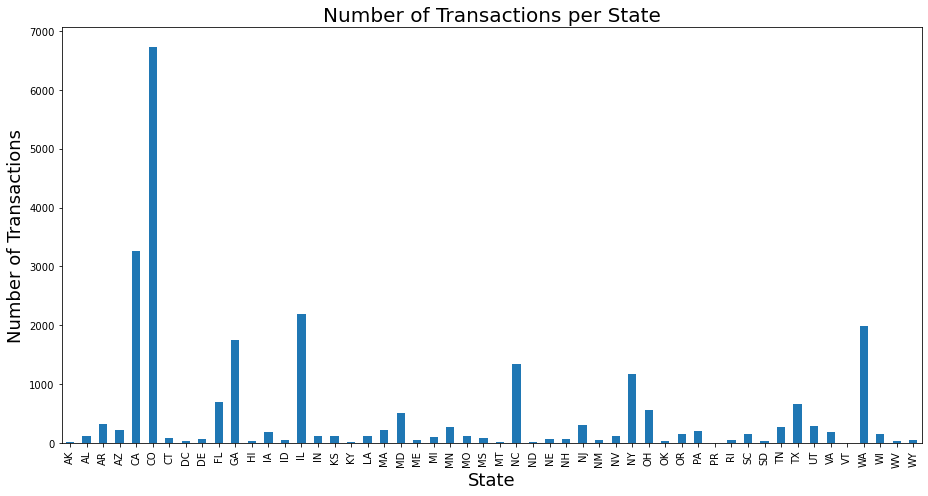

In [29]:
fig = plt.figure()
df_state=df.groupby(['state'])['state'].count()
df_state.plot.bar(figsize=(13,7))

plt.title('Number of Transactions per State', fontsize=20)
plt.xlabel("State", fontsize=18)
plt.ylabel("Number of Transactions", fontsize=18)
plt.legend('', frameon=False)
plt.tight_layout()
fig.savefig('NumofTransactionsPerState.jpg')

#### Short commentary on above graph "Number of Transactions per State"

From above graph: CO has the most records (approx 7K)in this data, Next is CA (approx 4K) , followed by IL, NC, WA, and NY. 
All other states have considerably less number of records

### Number of Transactions per Category

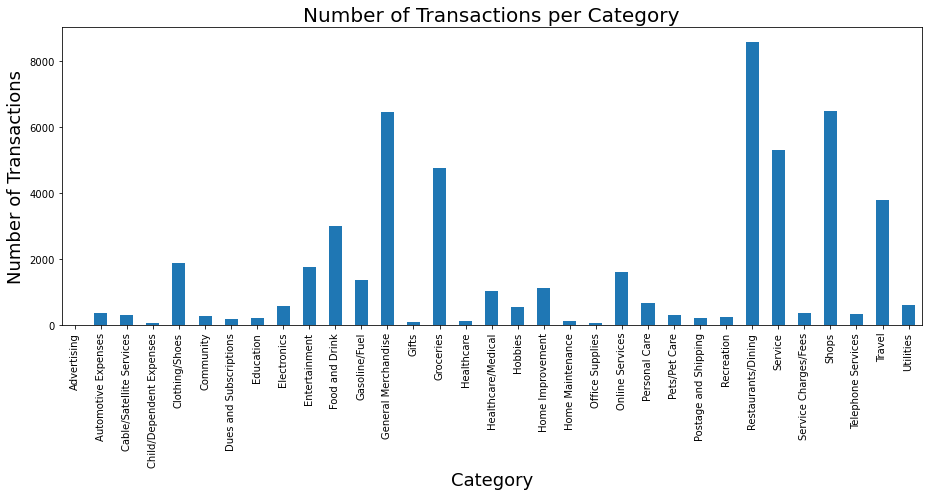

In [30]:
fig = plt.figure()
df_cat=df.groupby(['category'])['category'].count()
df_cat.plot.bar(figsize=(13,7))

plt.title('Number of Transactions per Category', fontsize=20)
plt.xlabel("Category", fontsize=18)
plt.ylabel("Number of Transactions", fontsize=18)
plt.legend('', frameon=False)
plt.tight_layout()
fig.savefig('NumofTransactrionsperCategory.jpg')

#### Short commentary on above graph "Number of Transactions per Category"

From above graph: the majority of records are coming from "Restaurants/Dining" Category.
Followed by "General Merchandise", "Shops", "Groceries", "Service", and "Travel".

### Total Amount Spent per Category

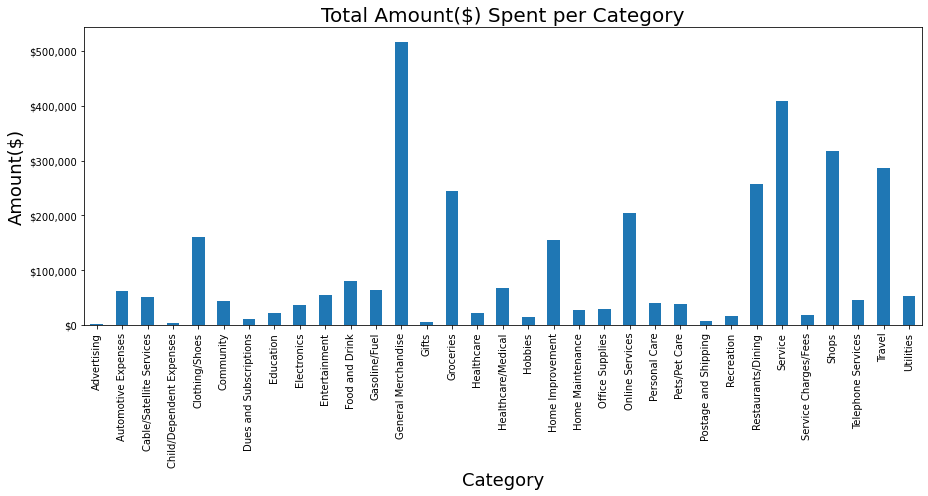

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(13, 7))

fmt = '${x:,.0f}'
df_amt_cat=df[['amountnum','category']].groupby('category').sum('amountnum')
df_amt_cat.plot.bar(ax=ax)


plt.title('Total Amount($) Spent per Category', fontsize=20)
plt.xlabel("Category", fontsize=18)
plt.ylabel("Amount($)", fontsize=18)

tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

plt.legend('', frameon=False)
plt.tight_layout()
fig.savefig('TotalAmountSpentPerCategory.jpg')

#df[['amountnum','category']].groupby('category').sum('amountnum').plot.bar()

#### Short commentary on above graph " Amount (\$\) Spent per Category"

The category where most $ were spent is "General Merchandise". "Service", "Travel", 
"Restaurants/Dining", "Groceries" come next.
There are a few categories that have almost zero amount spent. 

In [32]:
df_GM_merchant=df[df.category=='General Merchandise'].groupby('simple_description')['amountnum'].sum()
df_GM_merchant.max()

128008.47999999947

In [33]:
df_GM_merchant[df_GM_merchant==df_GM_merchant.max()]

simple_description
costco    128008.48
Name: amountnum, dtype: float64

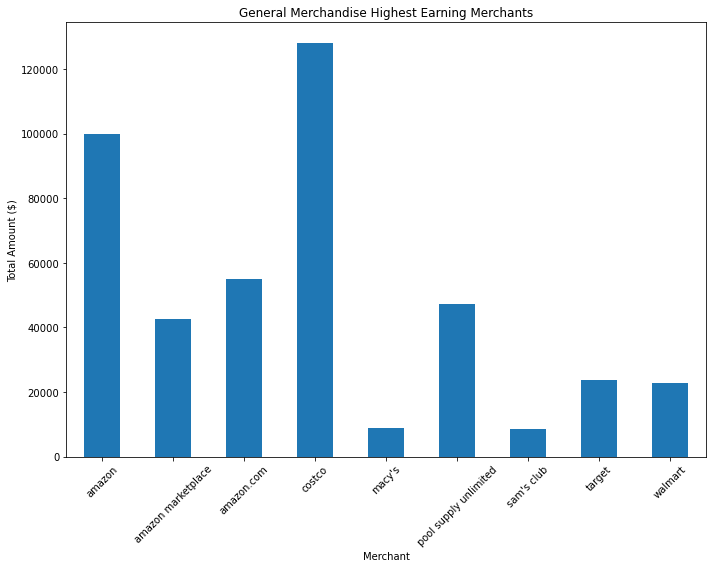

In [34]:
fig=plt.figure(figsize=(10,8))
df_GM_merchant[df_GM_merchant > 8000].plot(kind='bar')
plt.title('General Merchandise Highest Earning Merchants')
plt.xlabel('Merchant')
plt.xticks(rotation=45)
plt.ylabel('Total Amount ($)')
plt.tight_layout()
fig.savefig('General Merchandise Highest Earning Merchants')


## Date/Time Analysis

Creating a copy of 'df' with date as index. Also reordering columns to better view the data frame

In [35]:
df1=df[['date','uid','category','categoryid','simple_description','amountnum','city','state','zip_code','address','latitude','longitude','accountid']]
df1=df1.set_index('date')
df1.index=df1.index.normalize()
df1.info() #non-null rows=52757

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52757 entries, 2020-08-20 to 2019-09-01
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   uid                 52757 non-null  object 
 1   category            52757 non-null  object 
 2   categoryid          52757 non-null  float64
 3   simple_description  52757 non-null  object 
 4   amountnum           52757 non-null  float64
 5   city                20462 non-null  object 
 6   state               25484 non-null  object 
 7   zip_code            13377 non-null  object 
 8   address             9188 non-null   object 
 9   latitude            9291 non-null   float64
 10  longitude           9291 non-null   float64
 11  accountid           52757 non-null  float64
dtypes: float64(5), object(7)
memory usage: 5.2+ MB


### Highest Mean Amount($) Per Category

Which category has highest mean amount in each month?

,Highest_Cat,Mean_Amount
Month,,
7,Office Supplies,5656.750000
6,Office Supplies,2855.305000
4,Office Supplies,2831.910000
3,Office Supplies,2831.230000
5,Office Supplies,2826.265000
9,Home Maintenance,421.550000
1,Pets/Pet Care,369.270980
11,Automotive Expenses,334.226818
2,Cable/Satellite Services,301.087179


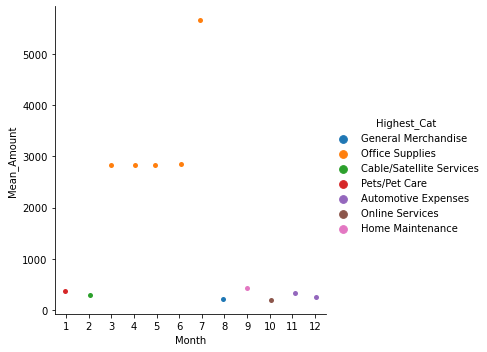

In [36]:
df_Office_Supply = pd.DataFrame(columns = ['Month', 'Highest_Cat', 'Mean_Amount'])

for month in list(df1.index.month.unique()):
    df1_mean=df1[df1.index.month==month].groupby(['category']).mean('amountnum')['amountnum']
    cat=df1_mean.sort_values(ascending=False).index[0]
    amt=df1_mean.sort_values(ascending=False)[0]
    df_Office_Supply=df_Office_Supply.append({'Month' : month, 'Highest_Cat' : cat, 'Mean_Amount' : amt}, ignore_index=True)

#Plot
sns.catplot(x="Month", y="Mean_Amount", hue='Highest_Cat', data=df_Office_Supply);

df_Office_Supply.set_index('Month').sort_values('Mean_Amount', ascending=False)


Looks like the months 3,4,5 and 7 have highest mean amount in the category "Office Supplies".

Dissecting the "Office Supplies" category to see why is this happening?

In [37]:
#March
df1[(df1.index.month==3) & (df1.category=='Office Supplies')] #two rows from two different uid. $5637.50 exists in this month

,uid,category,categoryid,simple_description,amountnum,city,state,zip_code,address,latitude,longitude,accountid
date,,,,,,,,,,,,
2020-03-22,Q55Xf6Tz8QbyWddyCwakQT9DH9n1,Office Supplies,45.0,pq*plastiq bill paymsan ******* amxrrnx3532 re...,5637.50,NaN,None,NaN,None,NaN,NaN,10082151.0
2020-03-02,WdtUjyA3mghZ6TrphronQpCVrI23,Office Supplies,45.0,*pending debit mar02 p 4120at badass prints co...,24.96,NaN,None,NaN,None,NaN,NaN,10038937.0


In [38]:
#April
df1[(df1.index.month==4) & (df1.category=='Office Supplies')] 
#two rows from two different uid. $5637.50 ALSO exists in this month. Same exact row as above, except the date is now 2020-04-22 instead of 2020-03-22

,uid,category,categoryid,simple_description,amountnum,city,state,zip_code,address,latitude,longitude,accountid
date,,,,,,,,,,,,
2020-04-22,Q55Xf6Tz8QbyWddyCwakQT9DH9n1,Office Supplies,45.0,pq*plastiq bill paymsan ******* amxrrnx7230 re...,5637.50,NaN,None,NaN,None,NaN,NaN,10082151.0
2020-04-10,PlivnaMFITNbNHGJgdusJrKy93u1,Office Supplies,45.0,staples,26.32,NaN,None,NaN,None,NaN,NaN,10061375.0


In [39]:
#May
df1[(df1.index.month==5) & (df1.category=='Office Supplies')]
#two rows from two different uid. $5637.50 ALSO exists in this month.Same exact row as above, except the date is now 2020-05-20

,uid,category,categoryid,simple_description,amountnum,city,state,zip_code,address,latitude,longitude,accountid
date,,,,,,,,,,,,
2020-05-20,Q55Xf6Tz8QbyWddyCwakQT9DH9n1,Office Supplies,45.0,pq*plastiq bill paymsan ******* amxrrnx2052 re...,5637.50,NaN,None,NaN,None,NaN,NaN,10082151.0
2020-05-06,9zRfuniG3aXhDsd80zYy1ukeh2V2,Office Supplies,45.0,staples,15.03,NaN,MA,NaN,None,NaN,NaN,10202566.0


In [40]:
#June
df1[(df1.index.month==6) & (df1.category=='Office Supplies')]
#two rows from two different uid. $5637.5 ALSO exists in this month.Same exact row as above, except the date is now 2020-06-25

,uid,category,categoryid,simple_description,amountnum,city,state,zip_code,address,latitude,longitude,accountid
date,,,,,,,,,,,,
2020-06-25,wrHJZ3ZqRaO9VIPd55VTs6qHOpt2,Office Supplies,45.0,staples,73.11,Holland,MI,49424,2337 N Park Dr,42.811067,-86.091578,10018260.0
2020-06-25,Q55Xf6Tz8QbyWddyCwakQT9DH9n1,Office Supplies,45.0,pq*plastiq bill paymsan ******* amxrrnx6110 re...,5637.50,NaN,None,NaN,None,NaN,NaN,10082151.0


In [41]:
#July
df1[(df1.index.month==7) & (df1.category=='Office Supplies')]
#two rows from two different uid. $5637.75 ALSO exists in this month.Same exact row as above, except the date is now 2020-07-26

,uid,category,categoryid,simple_description,amountnum,city,state,zip_code,address,latitude,longitude,accountid
date,,,,,,,,,,,,
2020-07-26,Q55Xf6Tz8QbyWddyCwakQT9DH9n1,Office Supplies,45.0,pq*plastiq bill paymsan ******* amxrrnx9194 re...,5656.75,NaN,None,NaN,None,NaN,NaN,10082151.0


#### Keeping one entry per accountid in one of the months that it exists in.

In [42]:
#For accountid=10082151.0, deleting row from May, June, July. Keeping only March's row as is

In [43]:
#March
#Checking:

assert len(df1[(df1.index.month==3) & (df1.category=='Office Supplies') & (df1.accountid==10082151.0)]) !=0

In [44]:
df1.drop(df1[(df1.index.month==5) & (df1.category=='Office Supplies') & (df1.accountid==10082151.0)].index, inplace=True)

#Checking:
assert df1[(df1.index.month==5) & (df1.category=='Office Supplies') & (df1.accountid==10082151.0)].empty

In [45]:
df1.drop(df1[(df1.index.month==6) & (df1.category=='Office Supplies') & (df1.accountid==10082151.0)].index, inplace=True)

#Checking:
assert df1[(df1.index.month==6) & (df1.category=='Office Supplies') & (df1.accountid==10082151.0)].empty

In [46]:
df1.drop(df1[(df1.index.month==7) & (df1.category=='Office Supplies') & (df1.accountid==10082151.0)].index, inplace=True)

#Checking:
assert df1[(df1.index.month==7) & (df1.category=='Office Supplies') & (df1.accountid==10082151.0)].empty

### Why the mean amount in the month of August sky rocketed?

In [47]:
#From graph titled "Highest Mean Amount($) Per Category", the max mean amount in the month of Aug is in cat='General Merchandise"
#Dissecting August

In [48]:
len(df1[(df1.category=='General Merchandise') & (df1.index.month==8)].sort_values(by='amountnum', ascending=False))

#clearly just like multiple similar entries of "Office Supplies" category in April,in Aug there are several GM rows. 

416

### NOTE: Looks like there are several "similar" transations in General Merchandise category. I am going to stop going through each line and delete kinda duplicates for every category, as it will bring total transactions way down. 

### Mean Amount (\$\) Spent per Month

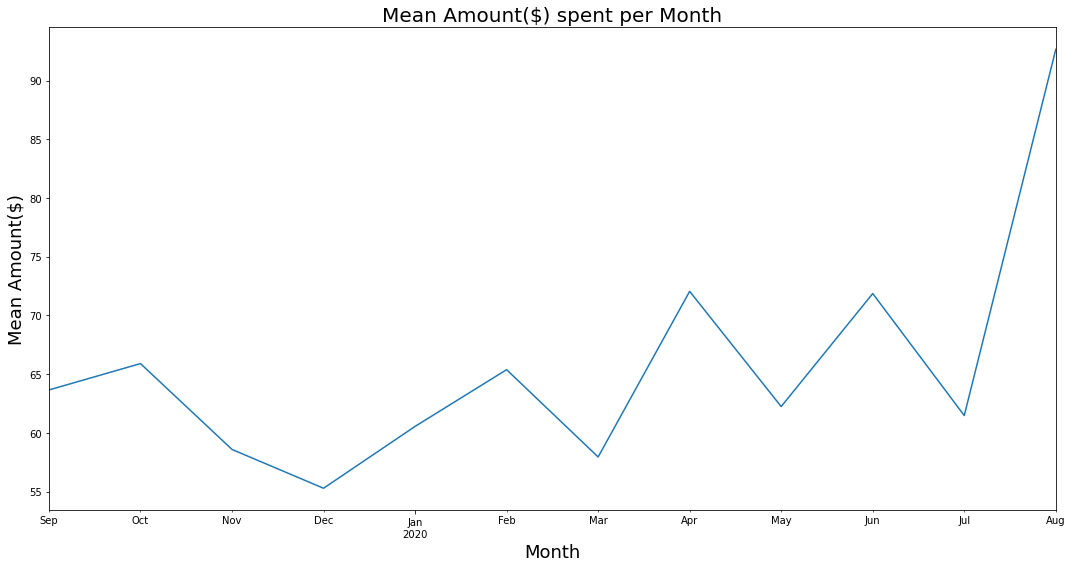

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
df1['amountnum'].resample('M').mean().plot(ax=ax)

plt.title('Mean Amount($) spent per Month', fontsize=20)
plt.xlabel("Month", fontsize=18)
plt.ylabel("Mean Amount($)", fontsize=18)
plt.tight_layout()
fig.savefig('MeanAmountspentpermonth.jpg')

#### Short commentary on above graph "Mean Amount Spent per Month"

There are clearly peaks (high and low) in different periods. I can't spot a pattern.

Q: Why does August have such high mean?

In [124]:
df_count_aug=df1[df1.index.month==8].groupby(['category'])['category'].count()
df_mean_aug=df1[df1.index.month==8].groupby('category')['amountnum'].sum()

df_mean_aug.sum()/df_count_aug.sum()  ### THIS IS THE NUMBER showing above. Less transaction and more $ amount spent

92.65274641148324

Q: Why does July have low mean?

In [126]:
df_count_july=df1[df1.index.month==7].groupby(['category'])['category'].count()
df_mean_july=df1[df1.index.month==7].groupby('category')['amountnum'].sum()

df_mean_july.sum()/df_count_july.sum() ## Alot of transaction but the amount spent is lesser than August. 

61.47284704566232

In [50]:
#Mean Amount spent per category (all months)
df1.groupby(['category']).mean('amountnum')['amountnum'].sort_values(ascending=False) 

category
Home Maintenance            246.894414
Office Supplies             207.375714
Healthcare                  199.203796
Automotive Expenses         177.604023
Community                   164.223408
Cable/Satellite Services    155.909397
Telephone Services          143.901167
Home Improvement            138.191909
Online Services             129.827460
Pets/Pet Care               126.714470
Advertising                 117.635000
Education                   102.058296
Utilities                    86.692509
Clothing/Shoes               85.679026
General Merchandise          80.712999
Service                      77.497100
Travel                       75.764039
Recreation                   67.802564
Child/Dependent Expenses     67.516182
Healthcare/Medical           65.427986
Dues and Subscriptions       61.032784
Personal Care                60.922170
Electronics                  60.494460
Gifts                        56.721905
Service Charges/Fees         53.850540
Groceries       

### Mean Amount Per Category Per Month Starting From Jan 2020 to Aug 2020

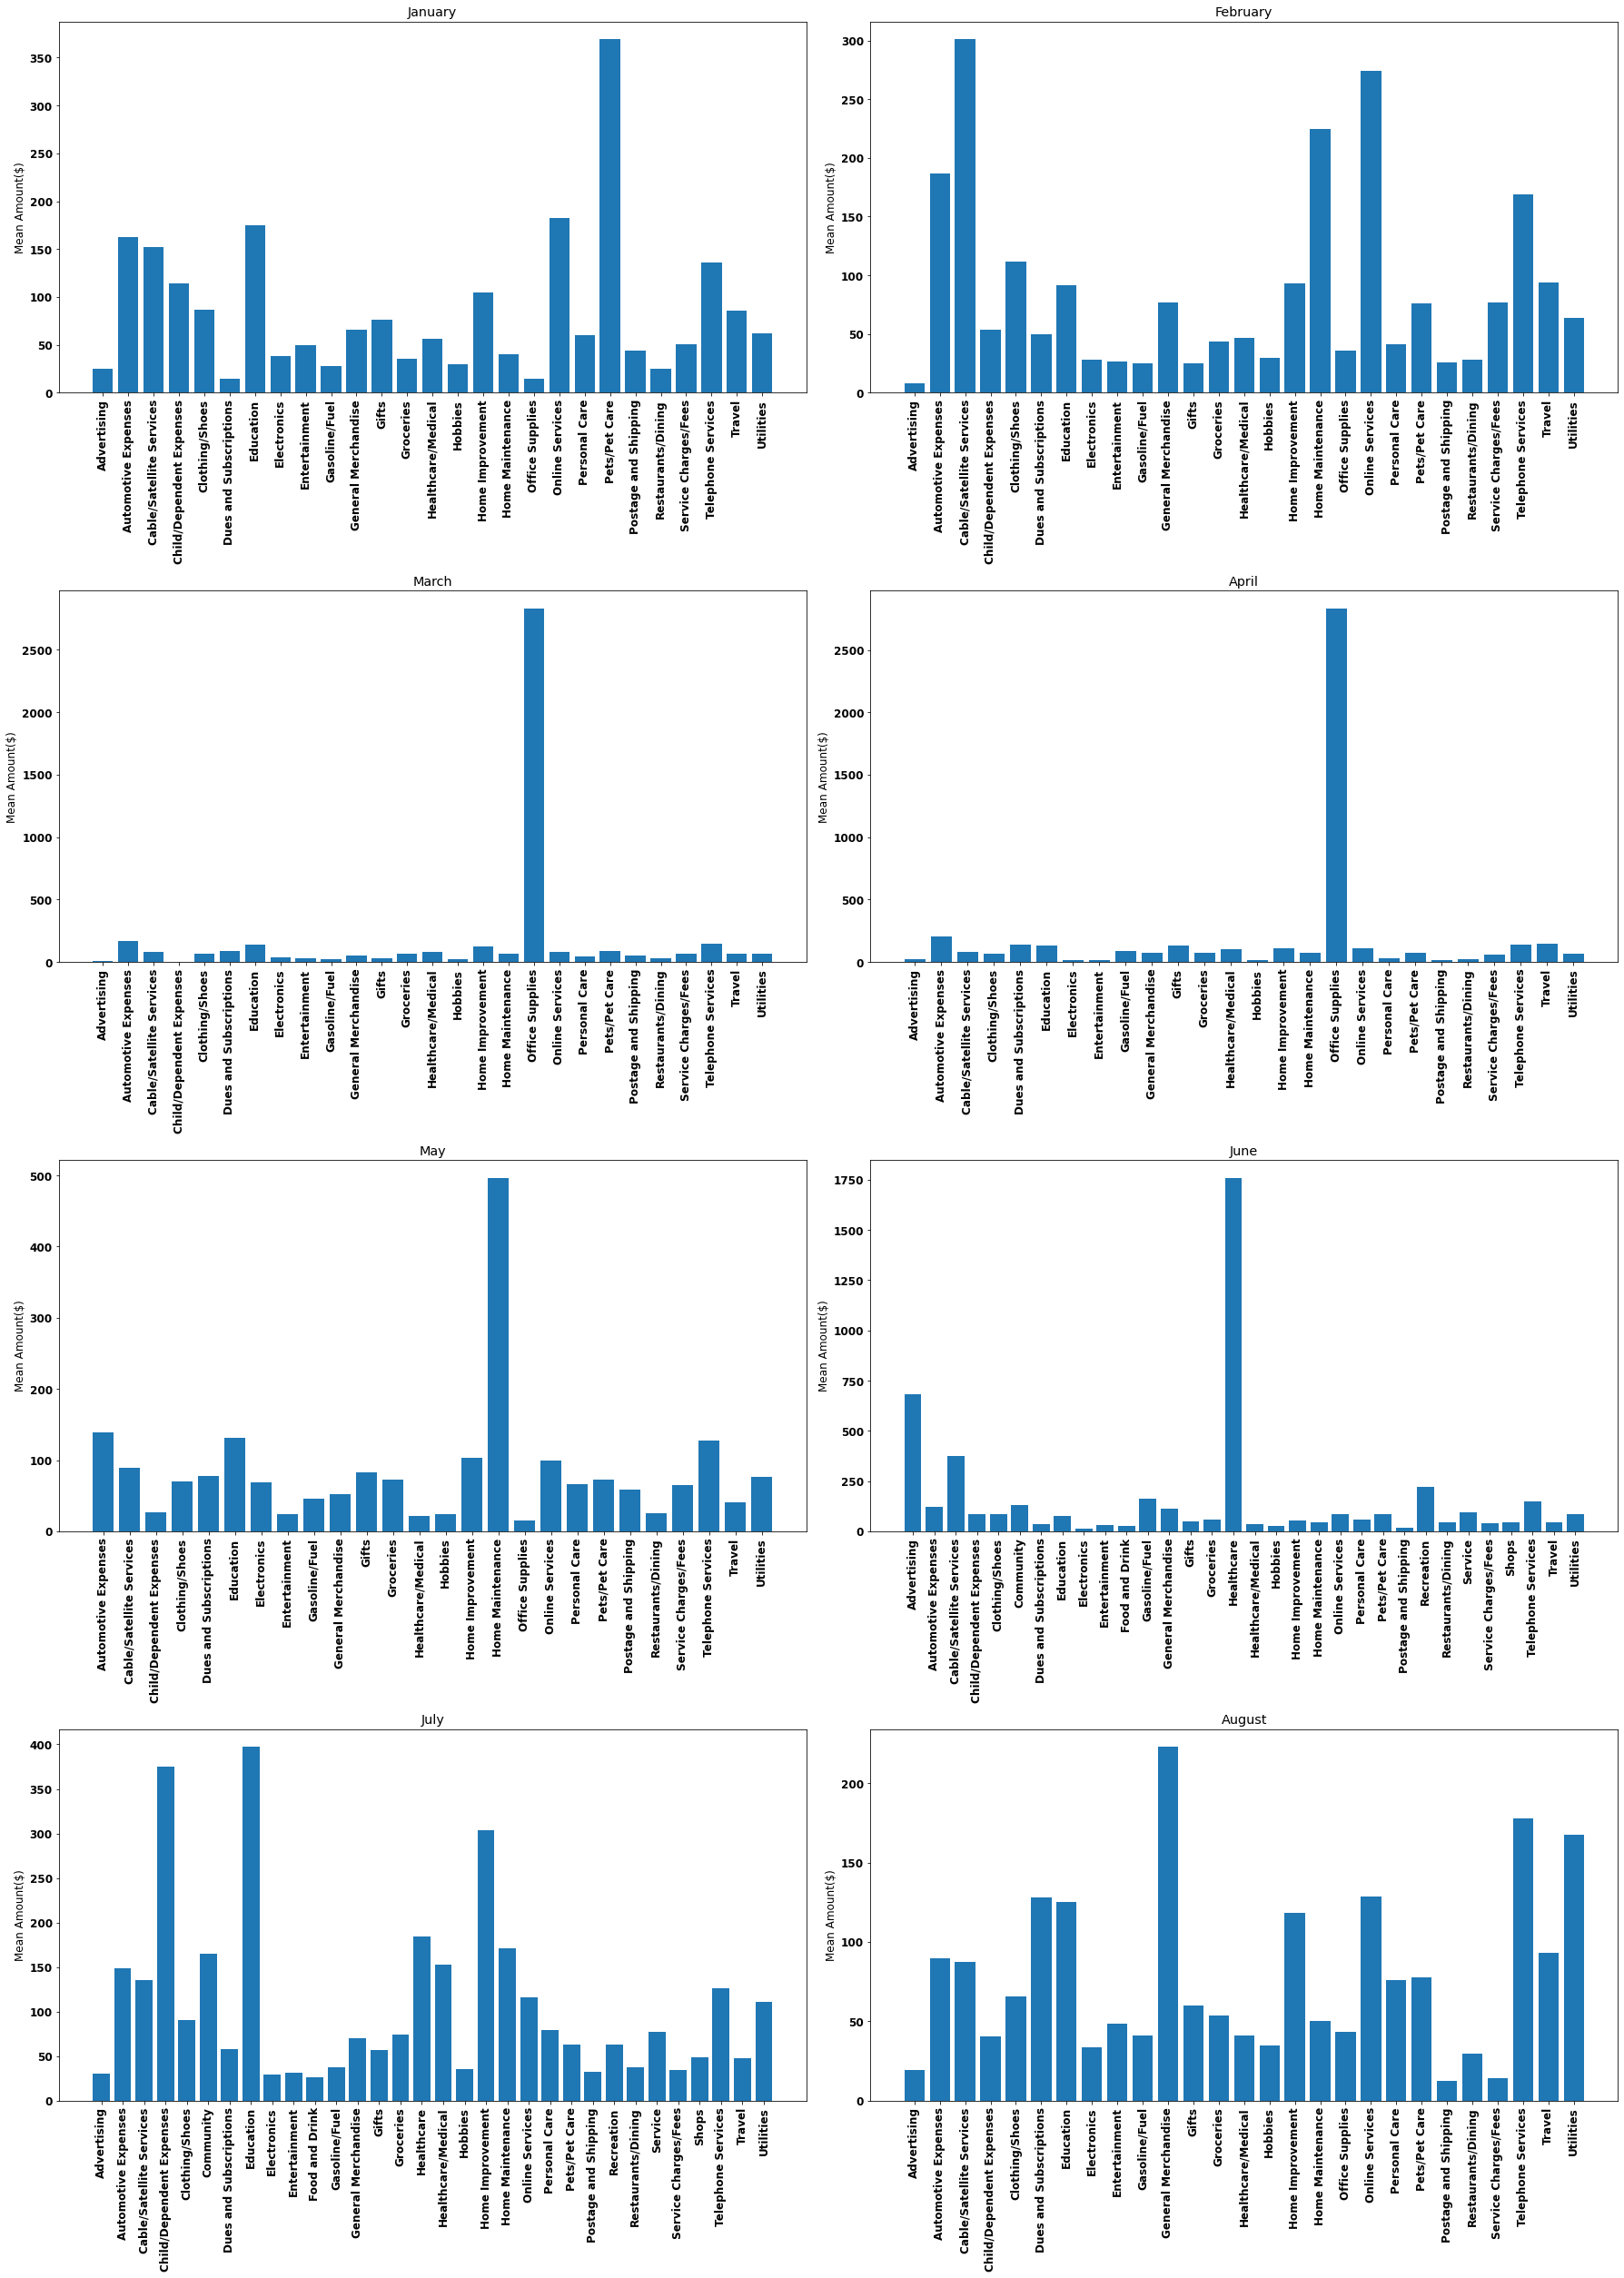

In [51]:
plt.rcParams["font.weight"] = "bold"
plt.rcParams["font.size"] = 12
fig, ax =plt.subplots(4,2)
fig.set_size_inches(25, 35, forward=True)
catPerMonthGraph2(1,df1,ax[0,0])
catPerMonthGraph2(2,df1,ax[0,1])
catPerMonthGraph2(3,df1,ax[1,0])
catPerMonthGraph2(4,df1,ax[1,1])
catPerMonthGraph2(5,df1,ax[2,0])
catPerMonthGraph2(6,df1,ax[2,1])
catPerMonthGraph2(7,df1,ax[3,0])
catPerMonthGraph2(8,df1,ax[3,1])
plt.tight_layout()
fig.savefig('PerMonthMeanAmountPerCategory.jpg')

#Jan 2020: most mean amount spent was on pets and least amount was spent on "office supplies"
#Feb 2020: most mean amount spent was on Cable/Satellite Services and least was spent on "Advertising"
#March 2020: Most mean amount was spent on "Office Supplies" and least was on everything else
#April 2020: Looks pretty much same as March 2020
#May 2020: Most mean amount was spent on "Home Maintenance" and least amount was spent on "office supplies"
#June 2020: Most mean amount was spent on "Health Care" and least amount was on "Electronics"
#July 2020: Most mean amount was spent on Education and least mean amount was spent on "Food and Drink"
#Aug 2020: Most mean amount was spent on General Merchandise and least mean amount was spent on "Postage and Shipping"

In [128]:
df1.info() #52262 rows of non Null Values. This will be ported to recommendation_system_v1.ipynb

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52262 entries, 2020-08-20 to 2019-09-01
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   uid                 52262 non-null  object 
 1   category            52262 non-null  object 
 2   categoryid          52262 non-null  float64
 3   simple_description  52262 non-null  object 
 4   amountnum           52262 non-null  float64
 5   city                20340 non-null  object 
 6   state               25333 non-null  object 
 7   zip_code            13292 non-null  object 
 8   address             9134 non-null   object 
 9   latitude            9234 non-null   float64
 10  longitude           9234 non-null   float64
 11  accountid           52262 non-null  float64
dtypes: float64(5), object(7)
memory usage: 5.2+ MB


## THE END

### Graphs below are re-draw of above. They were needed for adding to the report and the presentation

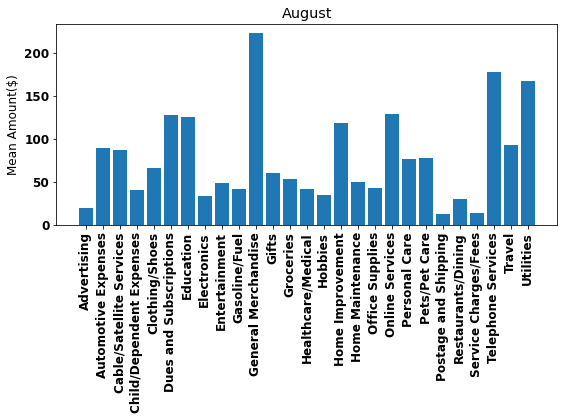

In [77]:
fig, ax =plt.subplots(1,1)
fig.set_size_inches(8, 6, forward=True)
catPerMonthGraph2(8,df1,ax)
plt.tight_layout()
fig.savefig('August-MeanAmt')

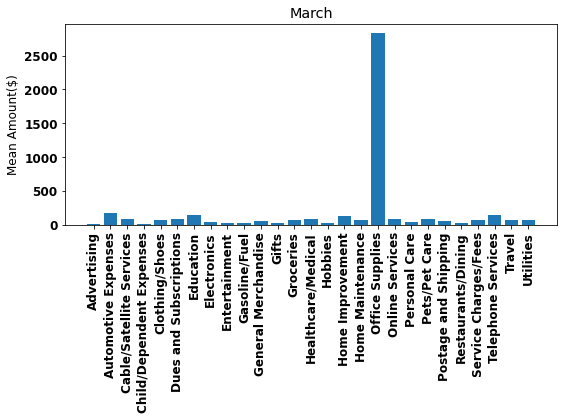

In [76]:
fig, ax =plt.subplots(1,1)
fig.set_size_inches(8, 6, forward=True)
catPerMonthGraph2(3,df1,ax)
plt.tight_layout()
fig.savefig('March-MeanAmt')

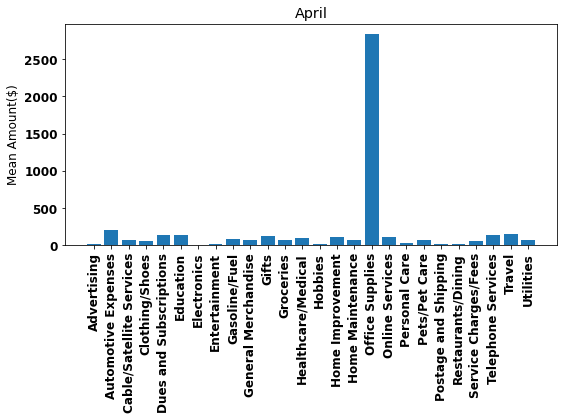

In [75]:
fig, ax =plt.subplots(1,1)
fig.set_size_inches(8,6, forward=True)
catPerMonthGraph2(4,df1,ax)
plt.tight_layout()
fig.savefig('April-MeanAmt')

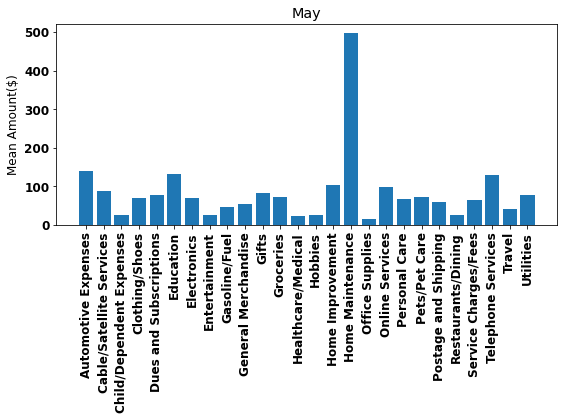

In [74]:
fig, ax =plt.subplots(1,1)
fig.set_size_inches(8,6, forward=True)
catPerMonthGraph2(5,df1,ax)
plt.tight_layout()
fig.savefig('May-MeanAmt')

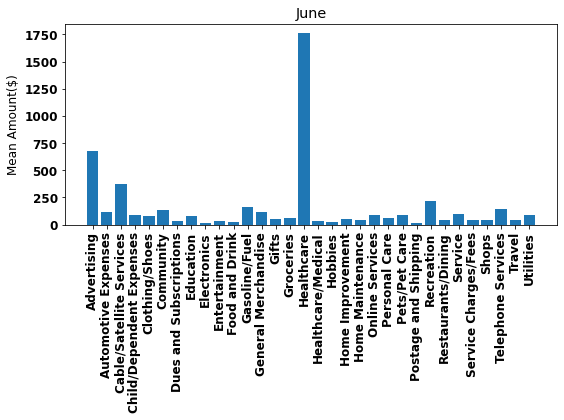

In [72]:
fig, ax =plt.subplots(1,1)
fig.set_size_inches(8,6, forward=True)
catPerMonthGraph2(6,df1,ax)
plt.tight_layout()
fig.savefig('June-MeanAmt')

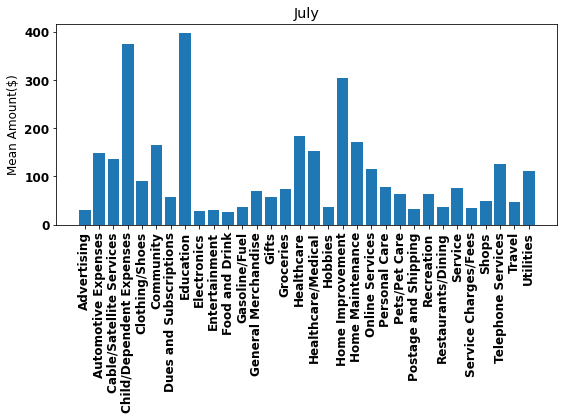

In [71]:
fig, ax =plt.subplots(1,1)
fig.set_size_inches(8,6, forward=True)
catPerMonthGraph2(7,df1,ax)
plt.tight_layout()
fig.savefig('July-MeanAmt')

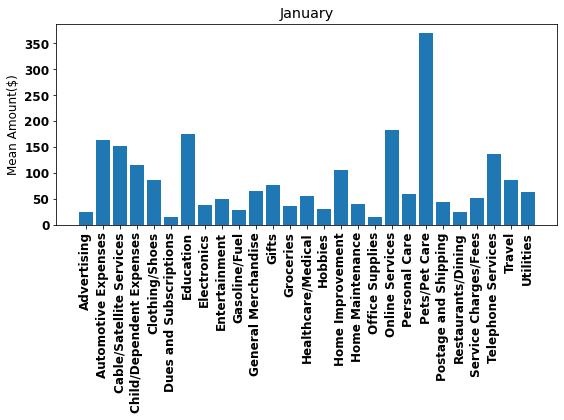

In [78]:
fig, ax =plt.subplots(1,1)
fig.set_size_inches(8,6, forward=True)
catPerMonthGraph2(1,df1,ax)
plt.tight_layout()
fig.savefig('January-MeanAmt')

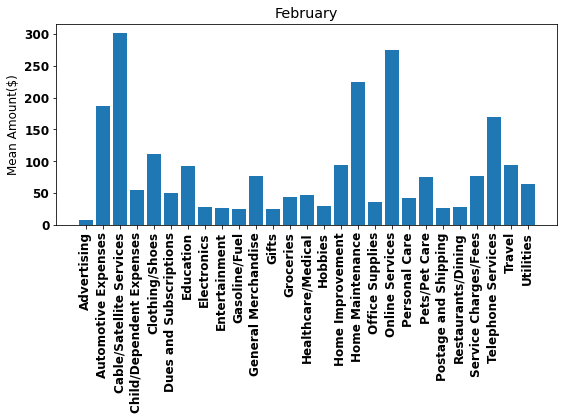

In [70]:
fig, ax =plt.subplots(1,1)
fig.set_size_inches(8,6, forward=True)
catPerMonthGraph2(2,df1,ax)
plt.tight_layout()
fig.savefig('February-MeanAmt')